In [79]:
import glob
import json
import os
import sys

from datetime import datetime
from functools import partial

import numpy as np
import pandas as pd
import pypdf
import matplotlib.pyplot as plt
import tabula
import zipfile

from matplotlib.dates import DateFormatter


pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.download import download_file_from_url
from src.utils.plot import (
    plot_bar,
    plot_hist,
    plot_pie,
    heatmap,
    PRIMARY_CMAP,
    PRIMARY_HEX,
    SECONDARY_HEX,
    TERTIARY_HEX,
)
from src.utils.states import abbrev_to_state

INPUT_DATA_DIR = "./input_data"
OUTPUT_IMAGE_DIR = "./images/pa_claims"
OUTPUT_DATA_DIR = "./output_data/pa_claims"  # Set to None if you don't want to save non-required data for external use

In [3]:
os.makedirs(INPUT_DATA_DIR, exist_ok=True)
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

issuer_path = os.path.join(OUTPUT_DATA_DIR, "issuers.csv")
plan_path = os.path.join(OUTPUT_DATA_DIR, "plans.csv")

In [4]:
def get_issuer_data(pdf_path):
    # Get issuer level data from first page
    issuer1_area = (171, 51, 562, 378)
    issuer1 = tabula.read_pdf(pdf_path, pages=1, area=issuer1_area)[0]
    plan_year_reporting = int(issuer1.iloc[0, 0][-6:-2])
    plan_year = plan_year_reporting + 2

    # Get issuer level data from second page
    issuer2_area = (171, 51, 600, 378)
    issuer2 = tabula.read_pdf(
        pdf_path,
        pages=2,
        area=issuer2_area,
        multiple_tables=False,
        stream=True,
        pandas_options={"header": None},
    )[0]

    # Get metadata values
    issuer_values = issuer2.iloc[:, 0].values
    on_exchange_in_plan_year_reporting = True if issuer_values[0] == "Yes" else False
    sadp_only = True if issuer_values[1] == "Yes" else False
    hios_issuer_id = int(issuer_values[2])

    # Claims
    claims_received = (
        int(issuer_values[3].replace(",", ""))
        if not pd.isna(issuer_values[3])
        else None
    )
    claims_denied = (
        int(issuer_values[4].replace(",", ""))
        if not pd.isna(issuer_values[4])
        else None
    )
    internal_appeals = (
        int(issuer_values[5].replace(",", ""))
        if not pd.isna(issuer_values[5])
        else None
    )
    internal_appeal_overturns = (
        int(issuer_values[6].replace(",", ""))
        if not pd.isna(issuer_values[6])
        else None
    )
    external_appeals = (
        int(issuer_values[7].replace(",", ""))
        if not pd.isna(issuer_values[7])
        else None
    )
    external_appeal_overturns = (
        int(issuer_values[8].replace(",", ""))
        if not pd.isna(issuer_values[8])
        else None
    )

    return (
        hios_issuer_id,
        plan_year,
        plan_year_reporting,
        sadp_only,
        claims_received,
        claims_denied,
        internal_appeals,
        internal_appeal_overturns,
        external_appeals,
        external_appeal_overturns,
    )


def convert_comma_string_to_int(val):
    if type(val) is not str:
        val = str(val)
        val = val.replace(".0", "")
    # Remove commas in strs, and erroneous str entries
    val = int(val.replace(",", "")) if val != "N/A" else None
    return val


def get_plan_data(pdf_path, plan_year, issuer_id):
    # Get total pdf page length
    reader = pypdf.PdfReader(open(pdf_path, mode="rb"))
    num_pages = len(reader.pages)

    if num_pages < 3:
        return pd.DataFrame()

    # Hardcode starting page in pdfs for plan-level data
    start_page = 3

    p_area = (171, 51, 800, 378)
    plans = tabula.read_pdf(
        pdf_path,
        pages=f"{start_page}-{num_pages}",
        guess=False,
        lattice=True,
        multiple_tables=True,
        pandas_options={"header": None},
    )

    plan_dfs = []

    # We will iterate over vertically split pieces within horizontally split pieces
    # Table is split horizontally into 3 pieces.
    # Number of vertical pieces for each horizontal piece varies by pdf, depending on total num records in table
    horizontal_pieces = 3
    assert len(plans) % horizontal_pieces == 0
    num_vertical_pieces = len(plans) // horizontal_pieces

    # Subsequent pages can be handled with consistent logic
    # Since no need to drop a row
    for pg_num in range(0, len(plans), num_vertical_pieces):
        vertical_pieces = []
        for voffset in range(0, num_vertical_pieces):
            p = plans[pg_num + voffset]
            if voffset == 0:
                if pg_num == 0:
                    p = p.drop(labels=0, axis=0).reset_index(drop=True)
                p.columns = p.iloc[0]
                p = p.drop(axis=0, labels=0)
            vertical_pieces.append(p)
        vertical_piece = pd.DataFrame(np.vstack(vertical_pieces))
        vertical_piece.columns = vertical_pieces[0].columns
        plan_dfs.append(vertical_piece)

    # Drop complete NA dfs that appear
    plan_dfs = [df for df in plan_dfs if not df.isnull().values.all()]

    # Drop complete NA rows
    df = pd.concat(plan_dfs, axis=1).dropna(how="all")

    # Add plan year column
    df["current_plan_year"] = plan_year
    df["data_plan_year"] = plan_year - 2

    # Add issuer id column
    df["hios_issuer_id"] = issuer_id

    # Rename columns
    df.columns = [
        "plan_id",
        "claims_received",
        "claims_denied",
        "claims_denied_prior_auth_referral",
        "claims_denied_oon_provider",
        "claims_denied_exclusion_of_service",
        "claims_denied_nmn_excl_behavioral",
        "claims_denied_nmn_behavioral",
        "claims_denied_other",
        "notes",
        "current_plan_year",
        "data_plan_year",
        "hios_issuer_id",
    ]

    # Cast int cols
    int_cols = [
        "claims_received",
        "claims_denied",
        "claims_denied_prior_auth_referral",
        "claims_denied_oon_provider",
        "claims_denied_exclusion_of_service",
        "claims_denied_nmn_excl_behavioral",
        "claims_denied_nmn_behavioral",
        "claims_denied_other",
    ]
    for int_col in int_cols:
        df[int_col] = (
            df[int_col].apply(convert_comma_string_to_int).astype(dtype="Int64")
        )

    return df


def convert_comma_string_to_int(val):
    if type(val) is not str:
        val = str(val)
        val = val.replace(".0", "")
    # Remove commas in strs, and erroneous str entries
    val = int(val.replace(",", "")) if val != "N/A" else None
    return val


def get_plan_data(pdf_path, plan_year, issuer_id):
    # Get total pdf page length
    reader = pypdf.PdfReader(open(pdf_path, mode="rb"))
    num_pages = len(reader.pages)

    if num_pages < 3:
        return pd.DataFrame()

    # Hardcode starting page in pdfs for plan-level data
    start_page = 3

    p_area = (171, 51, 800, 378)
    plans = tabula.read_pdf(
        pdf_path,
        pages=f"{start_page}-{num_pages}",
        guess=False,
        lattice=True,
        multiple_tables=True,
        pandas_options={"header": None},
    )

    plan_dfs = []

    # We will iterate over vertically split pieces within horizontally split pieces
    # Table is split horizontally into 3 pieces.
    # Number of vertical pieces for each horizontal piece varies by pdf, depending on total num records in table
    horizontal_pieces = 3
    assert len(plans) % horizontal_pieces == 0
    num_vertical_pieces = len(plans) // horizontal_pieces

    # Subsequent pages can be handled with consistent logic
    # Since no need to drop a row
    for pg_num in range(0, len(plans), num_vertical_pieces):
        vertical_pieces = []
        for voffset in range(0, num_vertical_pieces):
            p = plans[pg_num + voffset]
            if voffset == 0:
                if pg_num == 0:
                    p = p.drop(labels=0, axis=0).reset_index(drop=True)
                p.columns = p.iloc[0]
                p = p.drop(axis=0, labels=0)
            vertical_pieces.append(p)
        vertical_piece = pd.DataFrame(np.vstack(vertical_pieces))
        vertical_piece.columns = vertical_pieces[0].columns
        plan_dfs.append(vertical_piece)

    # Drop complete NA dfs that appear
    plan_dfs = [df for df in plan_dfs if not df.isnull().values.all()]

    # Drop complete NA rows
    df = pd.concat(plan_dfs, axis=1).dropna(how="all")

    # Add plan year column
    df["current_plan_year"] = plan_year
    df["data_plan_year"] = plan_year - 2

    # Add issuer id column
    df["hios_issuer_id"] = issuer_id

    # Rename columns
    df.columns = [
        "plan_id",
        "claims_received",
        "claims_denied",
        "claims_denied_prior_auth_referral",
        "claims_denied_oon_provider",
        "claims_denied_exclusion_of_service",
        "claims_denied_nmn_excl_behavioral",
        "claims_denied_nmn_behavioral",
        "claims_denied_other",
        "notes",
        "current_plan_year",
        "data_plan_year",
        "hios_issuer_id",
    ]

    # Cast int cols
    int_cols = [
        "claims_received",
        "claims_denied",
        "claims_denied_prior_auth_referral",
        "claims_denied_oon_provider",
        "claims_denied_exclusion_of_service",
        "claims_denied_nmn_excl_behavioral",
        "claims_denied_nmn_behavioral",
        "claims_denied_other",
    ]
    for int_col in int_cols:
        df[int_col] = (
            df[int_col].apply(convert_comma_string_to_int).astype(dtype="Int64")
        )

    return df

In [5]:
# data_dir = "/home/mike/persius/Public Records Request/PA/rtkl01609"
# pdf_paths = glob.glob(f"{data_dir}/**")


# # Issuer level, plan year claims denial data format:
# insurer_names = []
# issuer_hios_ids = []
# plan_years_reporting = []
# plan_years = []
# sadp_only_statuses = []
# claims_received = []  # received and DOS in plan_year
# claims_denied = []
# internal_appeals = []
# internal_appeal_overturns = []
# external_appeals = []
# external_appeal_overturns = []
# plan_dfs = []

# for pdf_path in pdf_paths:
#     try:
#         insurer_name = " ".join(pdf_path.split("/")[-1].split("-")[0].split(" ")[:-1])

#         # Get insurer-level data
#         (
#             hios_issuer_id,
#             plan_year,
#             plan_year_reporting,
#             sadp_only,
#             issuer_claims_received,
#             issuer_claims_denied,
#             issuer_internal_appeals,
#             issuer_internal_appeal_overturns,
#             issuer_external_appeals,
#             issuer_external_appeal_overturns,
#         ) = get_issuer_data(pdf_path)

#         # Append insurer-level data
#         insurer_names.append(insurer_name)
#         issuer_hios_ids.append(hios_issuer_id)
#         plan_years_reporting.append(plan_year_reporting)
#         plan_years.append(plan_year)
#         sadp_only_statuses.append(sadp_only)
#         claims_received.append(issuer_claims_received)
#         claims_denied.append(issuer_claims_denied)
#         internal_appeals.append(issuer_internal_appeals)
#         internal_appeal_overturns.append(issuer_internal_appeal_overturns)
#         external_appeals.append(issuer_external_appeals)
#         external_appeal_overturns.append(issuer_external_appeal_overturns)

#         # Get plan-level data
#         plan_data = get_plan_data(
#             pdf_path, plan_year=plan_year, issuer_id=hios_issuer_id
#         )
#         if len(plan_data) > 0:
#             plan_dfs.append(plan_data)

#     except Exception as e:
#         print(pdf_path)
#         print(e)

# issuer_df = pd.DataFrame(
#     data={
#         "insurer_name": pd.Series(insurer_names, dtype=str),
#         "hios_id": pd.Series(issuer_hios_ids, dtype=int),
#         "data_plan_year": pd.Series(plan_years_reporting, dtype=int),
#         "current_plan_year": pd.Series(plan_years, dtype=int),
#         "sadp_only": sadp_only_statuses,
#         "claims_received": pd.Series(claims_received, dtype="Int64"),
#         "claims_denied": pd.Series(claims_denied, dtype="Int64"),
#         "internal_appeals": pd.Series(internal_appeals, dtype="Int64"),
#         "internal_appeal_overturns": pd.Series(
#             internal_appeal_overturns, dtype="Int64"
#         ),
#         "external_appeals": pd.Series(external_appeals, dtype="Int64"),
#         "external_appeal_overturns": pd.Series(
#             external_appeal_overturns, dtype="Int64"
#         ),
#     }
# )

# plan_df = pd.concat(plan_dfs, axis=0)

# # Write dfs
# issuer_df.to_csv(issuer_path, index=False)
# plan_df.to_csv(plan_path, index=False)

In [6]:
# Read dfs
issuer_df = pd.read_csv(issuer_path)
plan_df = pd.read_csv(plan_path)

## Issuer Data

In [ ]:
# TODO: Submit inquiry about lack of data for certain issuers (e.g. Independence)

In [25]:
# Throw out issuer records with unbelievable claims numbers (e.g. 1 claim in 2021)
MIN_CLAIMS = 100
issuer_df = issuer_df[issuer_df["claims_received"] >= MIN_CLAIMS]

In [27]:
def get_overall_issuer_rates_by_year(issuer_df: pd.DataFrame, data_year: int) -> tuple:
    """Get aggregate denial and appeal rates across issuers."""
    df = issuer_df[issuer_df["data_plan_year"] == data_year].copy(deep=True)

    # Add relevant issuer level rates
    # Note: this data includes non-marketplace plans info (unlike plan level df)
    df["denial_rate"] = df["claims_denied"] / df["claims_received"]
    df["internal_appeal_rate"] = df["internal_appeals"] / df["claims_denied"]
    df["internal_appeal_success_rate"] = (
        df["internal_appeal_overturns"] / df["internal_appeals"]
    )
    df["external_appeal_rate"] = df["external_appeals"] / (
        df["internal_appeals"] - df["internal_appeal_overturns"]
    )
    df["external_appeal_success_rate"] = (
        df["external_appeal_overturns"] / df["external_appeals"]
    )

    # Compute totals across issuers
    issuer_claims_received = df["claims_received"].sum()
    issuer_denials = df["claims_denied"].sum()
    issuer_internal_appeals = df["internal_appeals"].sum()
    issuer_internal_appeal_overturns = df["internal_appeal_overturns"].sum()
    issuer_external_appeals = df["external_appeals"].sum()
    issuer_external_appeal_overturns = df["external_appeal_overturns"].sum()

    overall_denial_rate = issuer_denials / issuer_claims_received
    overall_internal_appeal_rate = issuer_internal_appeals / issuer_denials
    overall_internal_appeal_success_rate = (
        issuer_internal_appeal_overturns / issuer_internal_appeals
    )
    overall_external_appeal_rate = issuer_external_appeals / (
        issuer_internal_appeals - issuer_internal_appeal_overturns
    )
    overall_external_appeal_success_rate = (
        issuer_external_appeal_overturns / issuer_external_appeals
    )

    print(f"\tOverall denial rate: {overall_denial_rate:.2}")
    print(f"\tOverall internal appeal rate: {overall_internal_appeal_rate:.2}")
    print(
        f"\tOverall internal appeal success rate: {overall_internal_appeal_success_rate:.2}"
    )
    print(f"\tOverall external appeal rate: {overall_external_appeal_rate:.2}")
    print(
        f"\tOverall external appeal success rate: {overall_external_appeal_success_rate:.2}"
    )

    return df

In [28]:
year_dfs = []
for year in issuer_df["data_plan_year"].unique():
    print(f"{year} issuer data:")
    year_df = get_overall_issuer_rates_by_year(issuer_df, year)
    year_dfs.append(year_df)

2021 issuer data:
	Overall denial rate: 0.15
	Overall internal appeal rate: 0.00074
	Overall internal appeal success rate: 0.59
	Overall external appeal rate: 0.078
	Overall external appeal success rate: 0.23
2020 issuer data:
	Overall denial rate: 0.13
	Overall internal appeal rate: 0.0012
	Overall internal appeal success rate: 0.6
	Overall external appeal rate: 0.1
	Overall external appeal success rate: 0.27


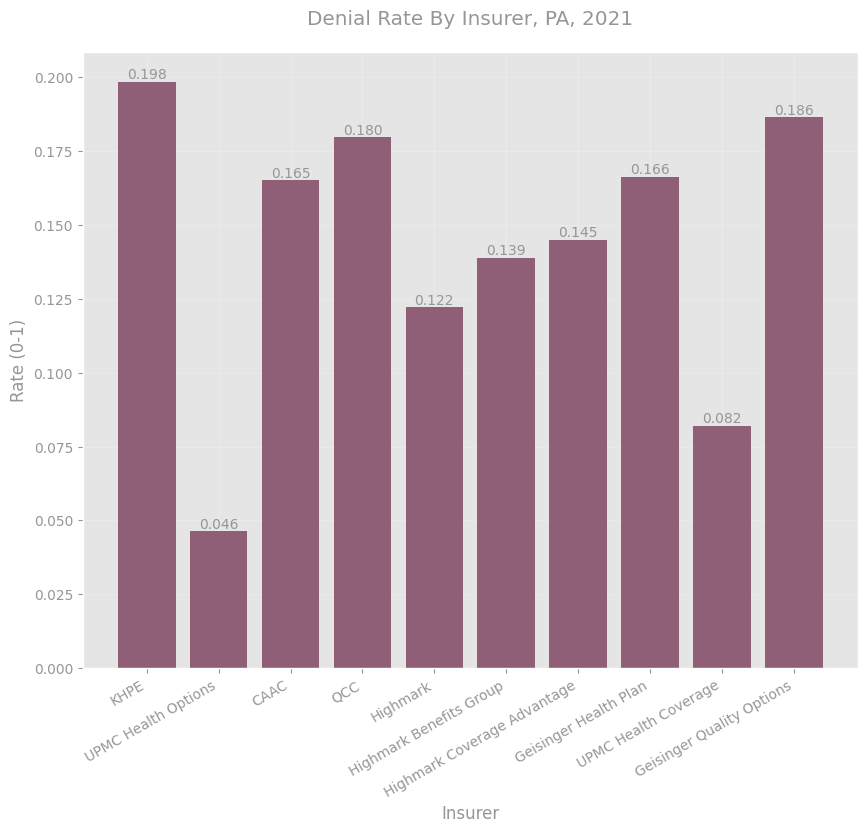

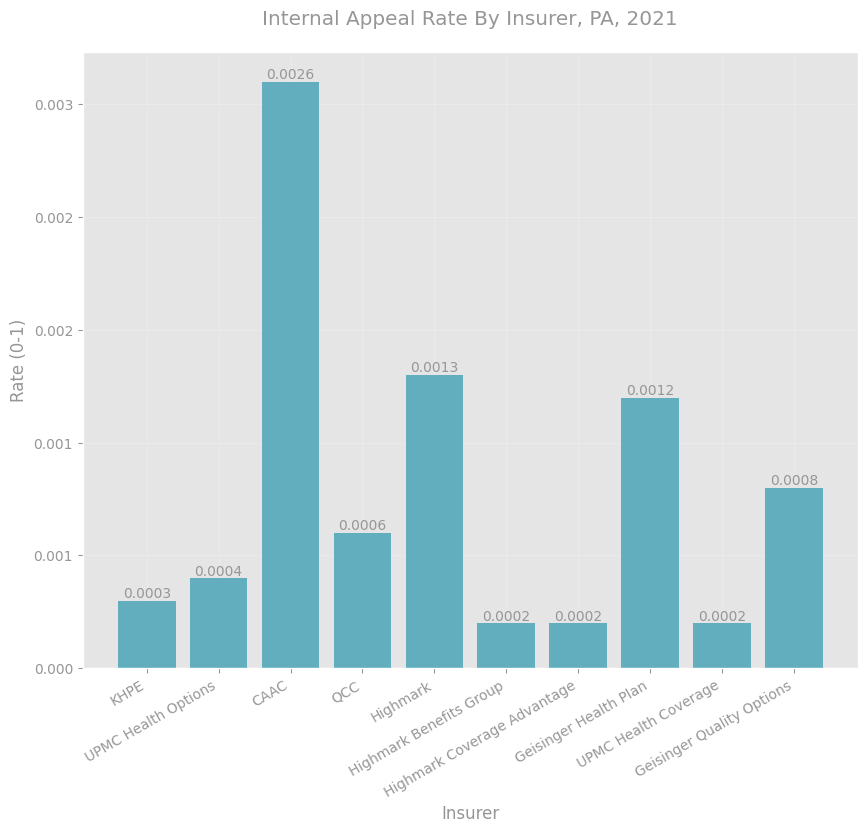

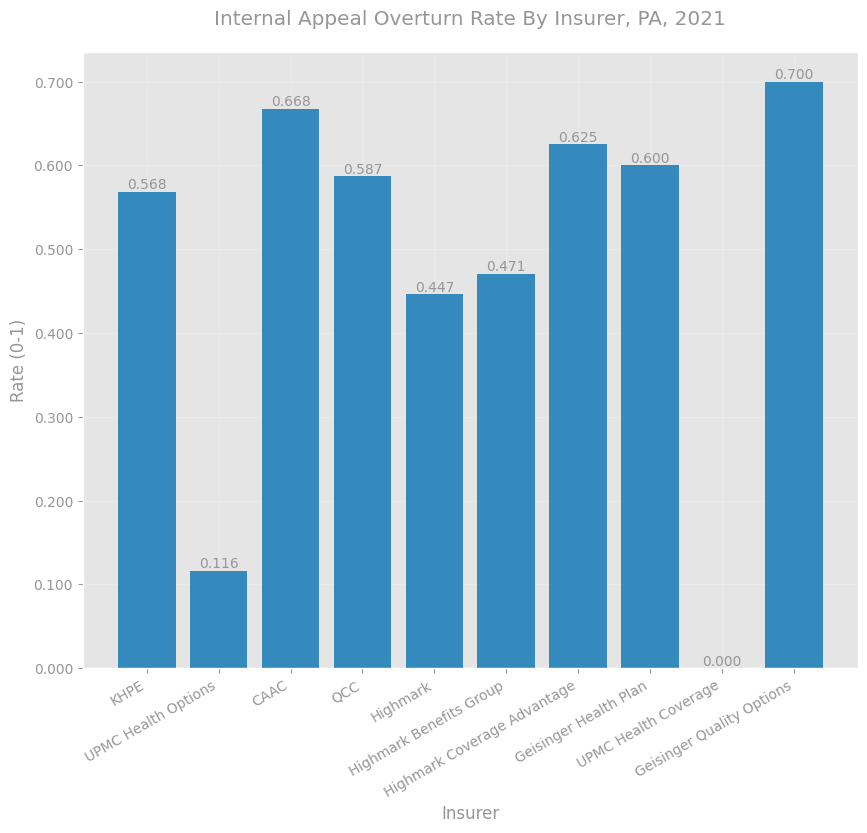

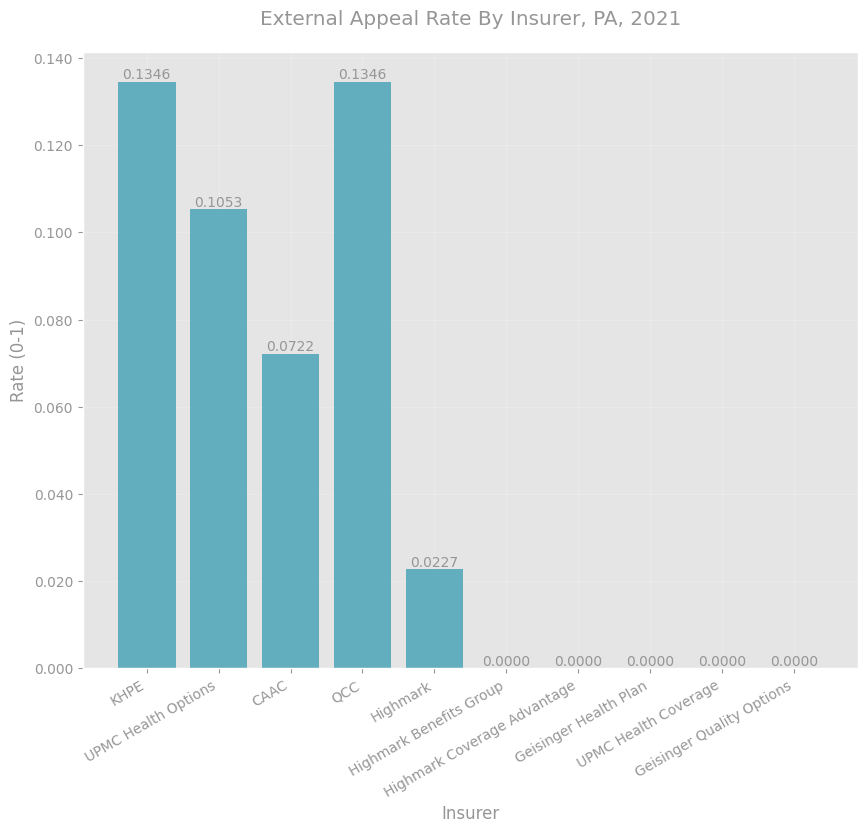

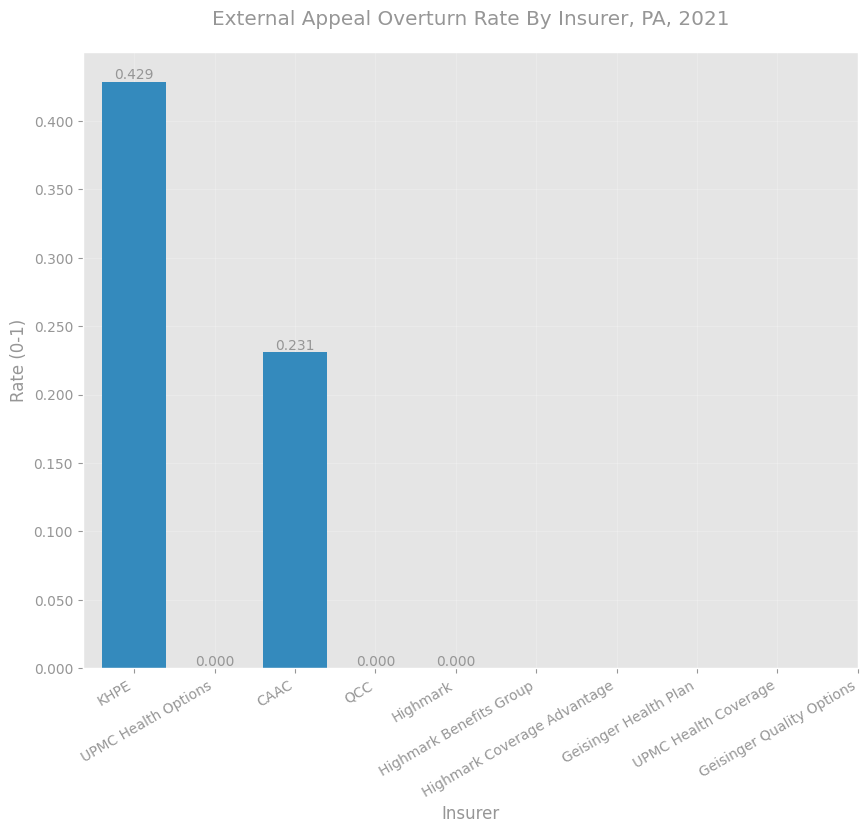

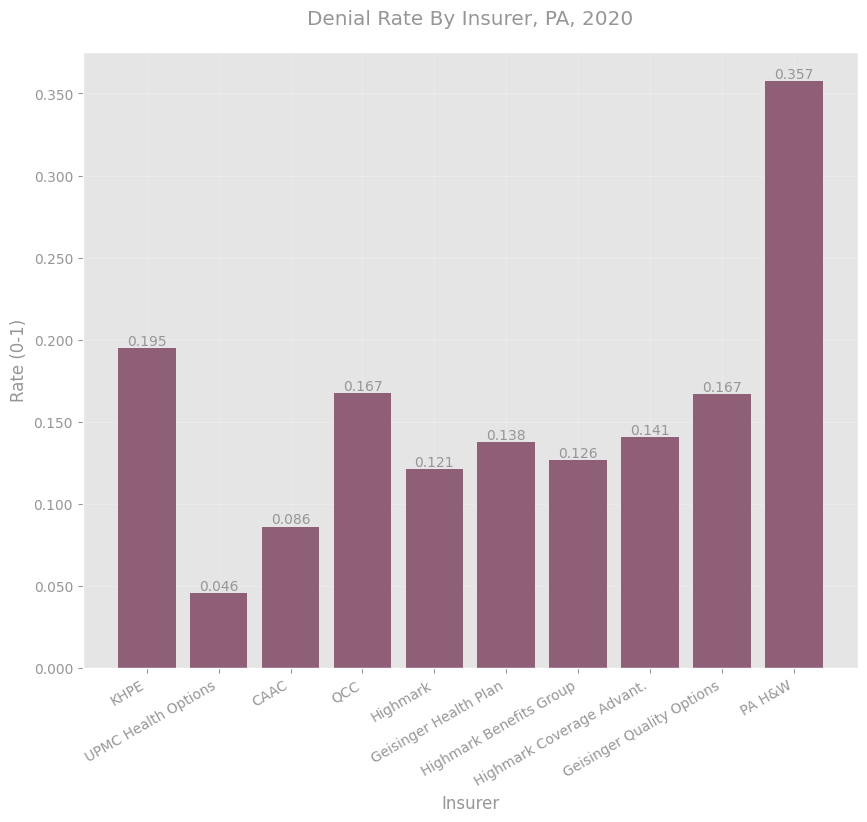

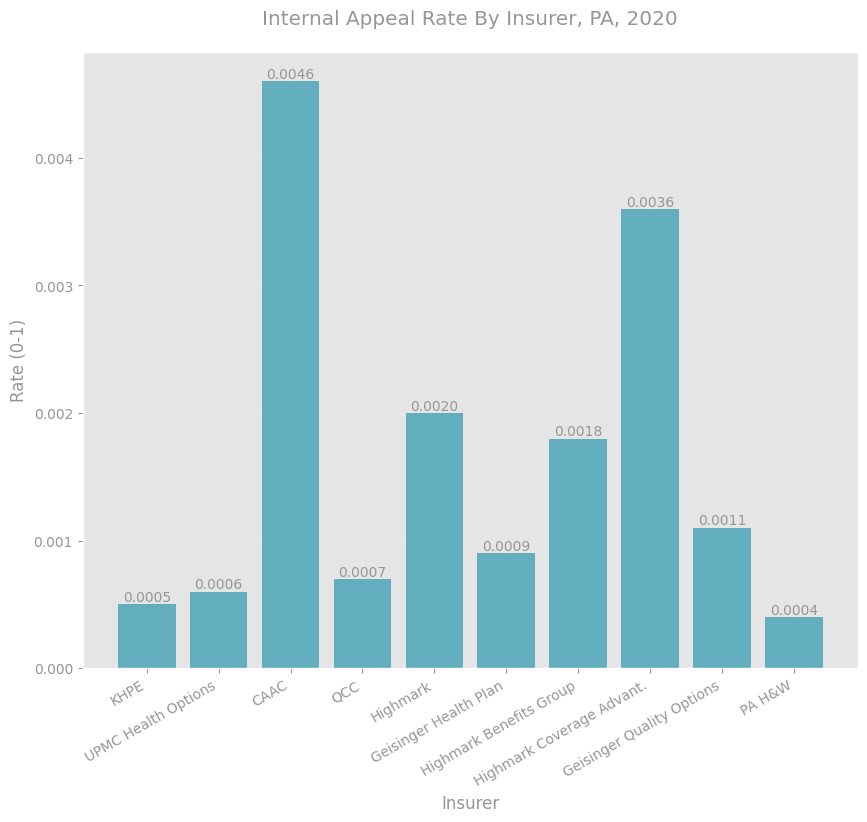

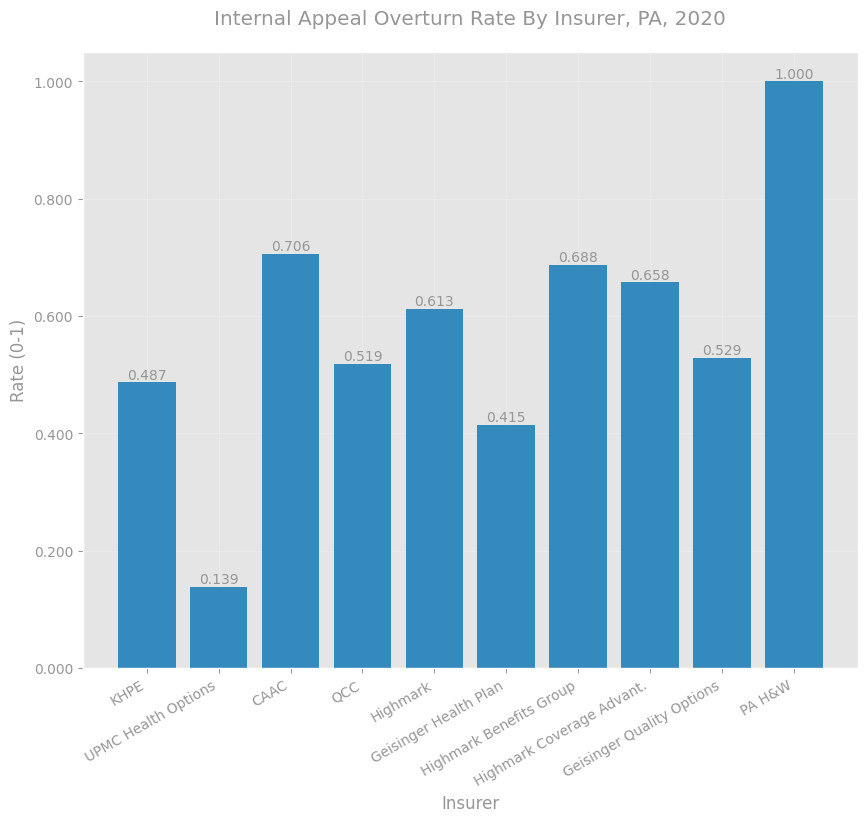

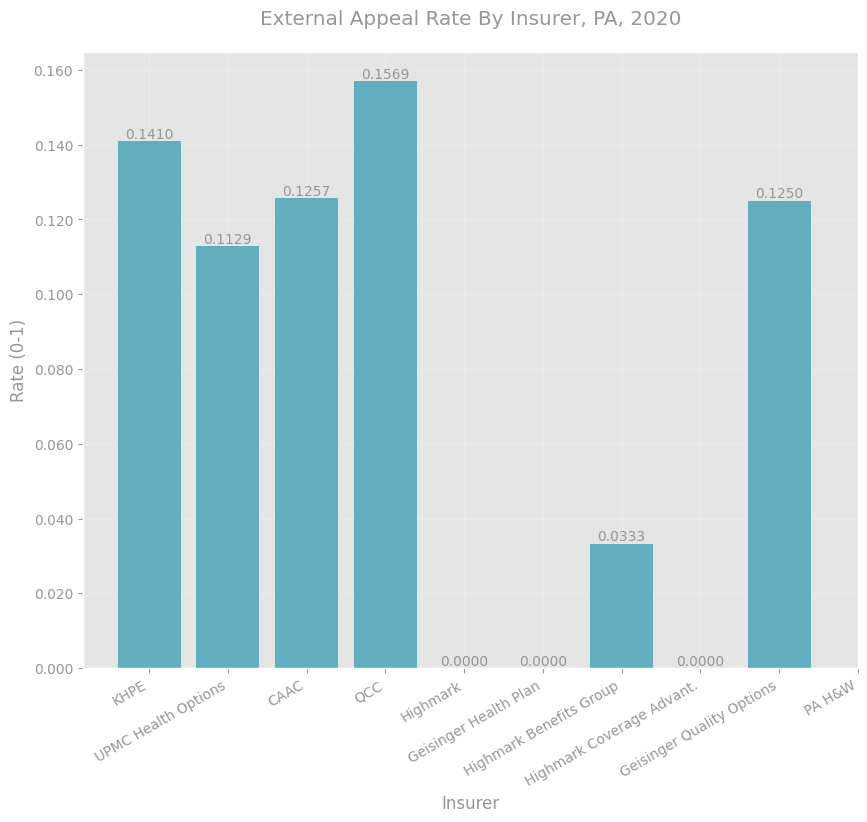

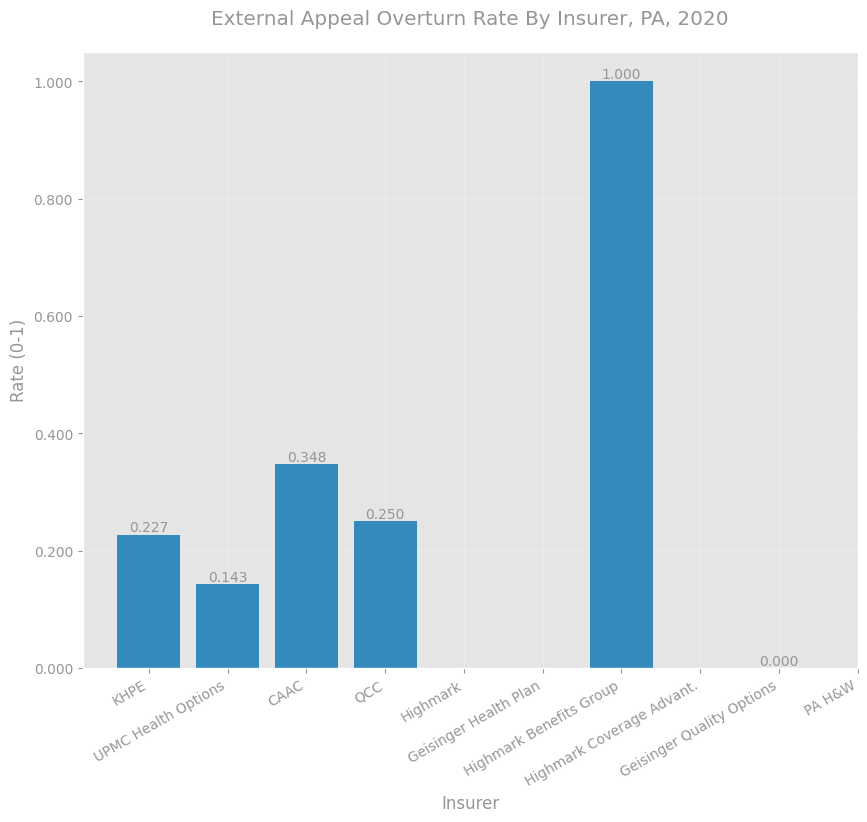

In [46]:
# Plot denial rates, appeal rates, success rates by insurer, by year
k = 10
for year_df in year_dfs:
    year = year_df["data_plan_year"].iloc[0]
    top_k = year_df.sort_values(by="claims_received", ascending=False)[:k]
    bar_names = top_k["insurer_name"].values
    bar_vals = [round(x, 6) for x in top_k["denial_rate"].values]
    val_axis_label = "Rate (0-1)"
    cat_axis_label = "Insurer"
    title = f"Denial Rate By Insurer, PA, {year}"
    plot_bar(
        bar_names,
        bar_vals,
        title=title,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(OUTPUT_IMAGE_DIR, f"denial_rate_by_insurer_{year}.png"),
        bar_label=True,
        int_vals=False,
        color_hex=PRIMARY_HEX,
        figsize=(10, 8),
    )

    bar_vals = [round(x, 4) for x in top_k["internal_appeal_rate"].values]
    val_axis_label = "Rate (0-1)"
    cat_axis_label = "Insurer"
    title = f"Internal Appeal Rate By Insurer, PA, {year}"
    plot_bar(
        bar_names,
        bar_vals,
        title=title,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(OUTPUT_IMAGE_DIR, f"appeal_rate_by_insurer_{year}.png"),
        bar_label=True,
        int_vals=False,
        color_hex=SECONDARY_HEX,
        float_precision_depth=4,
        figsize=(10, 8),
    )

    bar_vals = [round(x, 6) for x in top_k["internal_appeal_success_rate"].values]
    val_axis_label = "Rate (0-1)"
    cat_axis_label = "Insurer"
    title = f"Internal Appeal Overturn Rate By Insurer, PA, {year}"
    plot_bar(
        bar_names,
        bar_vals,
        title=title,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, f"internal_appeal_overturn_rate_by_insurer_{year}.png"
        ),
        bar_label=True,
        int_vals=False,
        color_hex=TERTIARY_HEX,
        figsize=(10, 8),
    )

    bar_vals = [round(x, 4) for x in top_k["external_appeal_rate"].values]
    val_axis_label = "Rate (0-1)"
    cat_axis_label = "Insurer"
    title = f"External Appeal Rate By Insurer, PA, {year}"
    plot_bar(
        bar_names,
        bar_vals,
        title=title,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, f"external_appeal_rate_by_insurer_{year}.png"
        ),
        bar_label=True,
        int_vals=False,
        color_hex=SECONDARY_HEX,
        float_precision_depth=4,
        figsize=(10, 8),
    )

    bar_vals = [round(x, 6) for x in top_k["external_appeal_success_rate"].values]
    val_axis_label = "Rate (0-1)"
    cat_axis_label = "Insurer"
    title = f"External Appeal Overturn Rate By Insurer, PA, {year}"
    plot_bar(
        bar_names,
        bar_vals,
        title=title,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, f"external_appeal_overturn_rate_by_insurer_{year}.png"
        ),
        bar_label=True,
        int_vals=False,
        color_hex=TERTIARY_HEX,
        figsize=(10, 8),
    )

## Marketplace Plan Data

In [48]:
# Throw out plan records with too few claims
MIN_CLAIMS = 100
plan_df = plan_df[plan_df["claims_received"] >= MIN_CLAIMS]

In [66]:
# verify denial rationales sum correctly
# Doesn't hold, presumably because they allow multiple rationales per claim,
# though even this doesn't hold for all records, as the below assertion shows
assert (
    plan_df["claims_denied"]
    <= (
        plan_df["claims_denied_prior_auth_referral"]
        + plan_df["claims_denied_oon_provider"]
        + plan_df["claims_denied_exclusion_of_service"]
        + plan_df["claims_denied_nmn_excl_behavioral"]
        + plan_df["claims_denied_nmn_behavioral"]
        + plan_df["claims_denied_other"]
    )
).all(), "Sum of denial rationales is not always greater than or equal to denial count."

AssertionError: Sum of denial rationales is not always greater than or equal to denial count.

In [67]:
def get_overall_plan_rates_by_year(plan_df: pd.DataFrame, data_year: int) -> tuple:
    """Get aggregate denial and appeal rates across issuers, from the plan df."""
    df = plan_df[plan_df["data_plan_year"] == data_year].copy(deep=True)

    # Add relevant plan level rates
    # Note: this data is marketplace plans only
    df["denial_rate"] = df["claims_denied"] / df["claims_received"]
    df["nmn_denial_rate"] = (
        df["claims_denied_nmn_excl_behavioral"] + df["claims_denied_nmn_behavioral"]
    ) / df["claims_received"]

    # Compute totals across marketplace plans
    plan_claims_received = df["claims_received"].sum()
    plan_denials = df["claims_denied"].sum()
    plan_nmn_denials = df["nmn_denial_rate"].sum()

    overall_denial_rate = plan_denials / plan_claims_received
    overall_nmn_denial_rate = plan_nmn_denials / plan_claims_received

    print(f"\tOverall denial rate: {overall_denial_rate:.2}")
    print(f"\tOverall NMN denial rate: {overall_nmn_denial_rate:.2}")
    return df

In [68]:
year_dfs = []
for year in plan_df["data_plan_year"].unique():
    print(f"{year} plan data:")
    year_df = get_overall_plan_rates_by_year(plan_df, year)
    year_dfs.append(year_df)

2021 plan data:
	Overall denial rate: 0.14
	Overall NMN denial rate: 2.1e-07
2020 plan data:
	Overall denial rate: 0.12
	Overall NMN denial rate: 4.6e-08


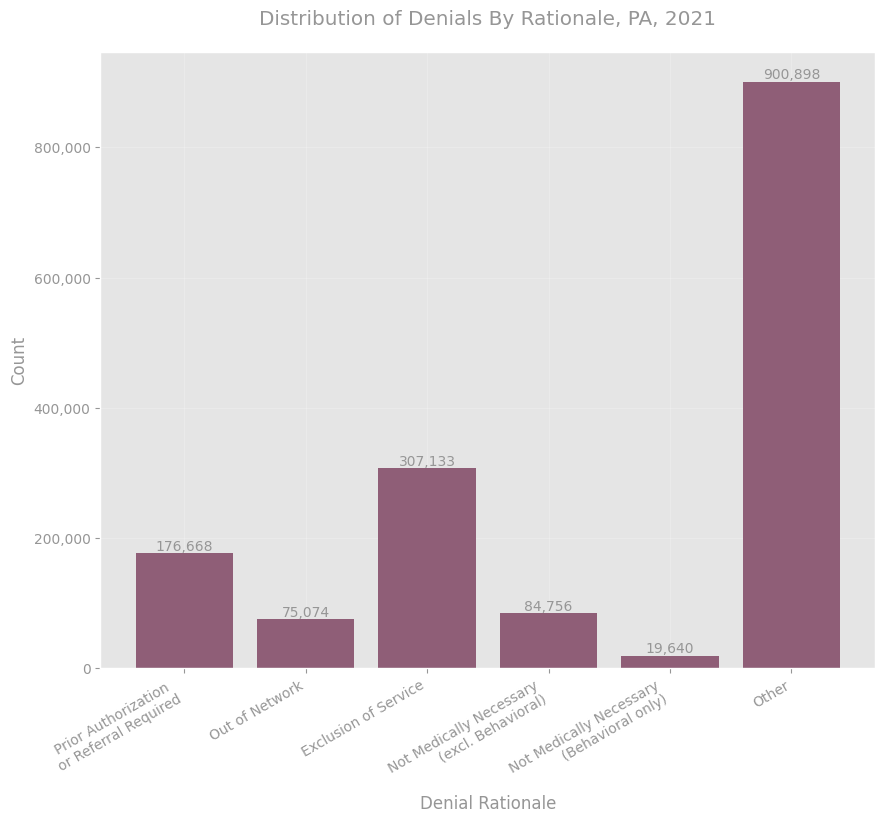

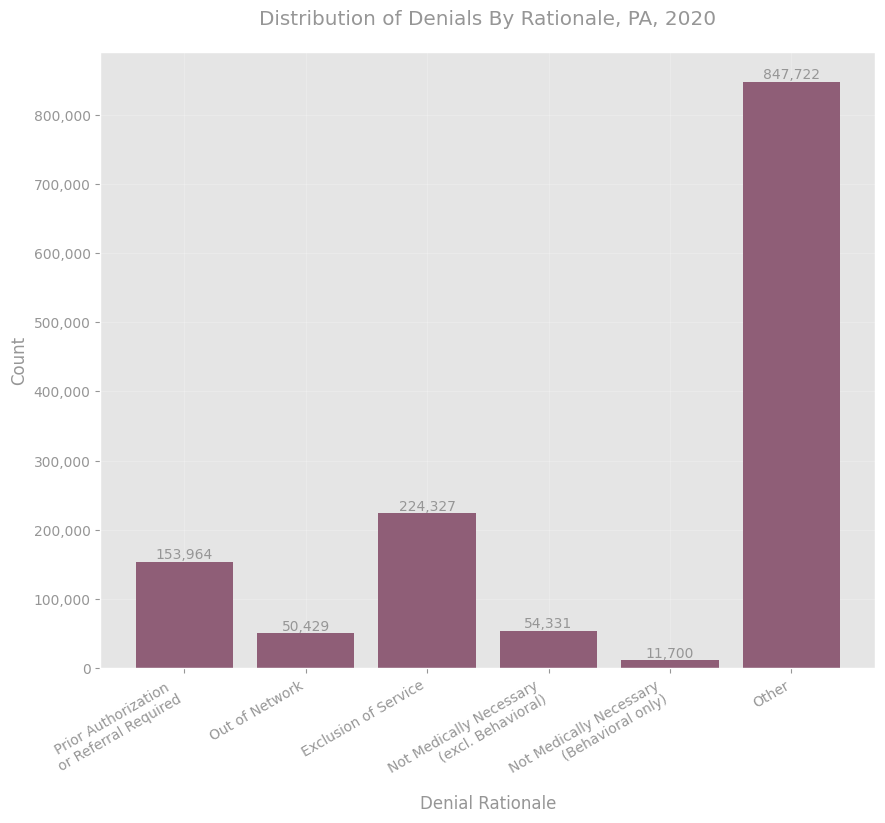

In [76]:
# Plot denial rationale breakdown across all plans, by year
rationale_cat_map = {
    "claims_denied_prior_auth_referral": "Prior Authorization \nor Referral Required",
    "claims_denied_oon_provider": "Out of Network",
    "claims_denied_exclusion_of_service": "Exclusion of Service",
    "claims_denied_nmn_excl_behavioral": "Not Medically Necessary\n (excl. Behavioral)",
    "claims_denied_nmn_behavioral": "Not Medically Necessary\n (Behavioral only)",
    "claims_denied_other": "Other",
}

for year_df in year_dfs:
    year = year_df["data_plan_year"].iloc[0]
    bar_vals = [year_df[col].sum() for col in rationale_cat_map.keys()]
    bar_names = list(rationale_cat_map.values())
    title = f"Distribution of Denials By Rationale, PA, {year}"
    val_axis_label = "Count"
    cat_axis_label = "Denial Rationale"

    plot_bar(
        bar_names,
        bar_vals,
        title=title,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        bar_label=True,
        figsize=(10, 8),
        save_path=os.path.join(OUTPUT_IMAGE_DIR, f"denial_rationale_dist_{year}.png"),
    )

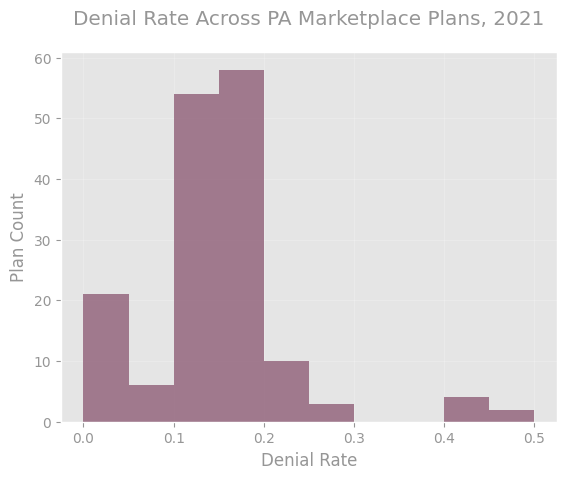

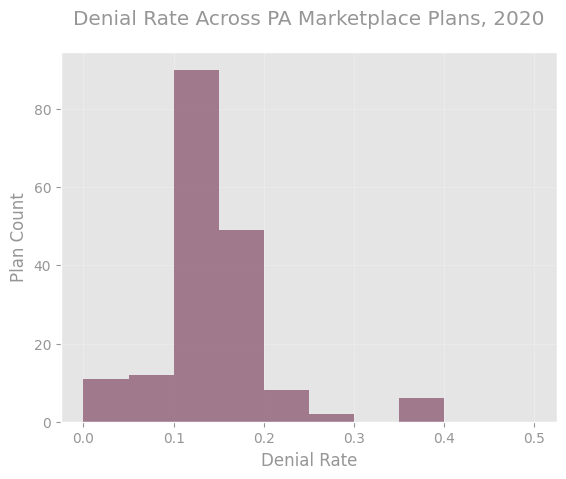

In [83]:
# Denial Rate Distributions Across Plans
for year_df in year_dfs:
    year = year_df["data_plan_year"].iloc[0]
    plot_hist(
        year_df["denial_rate"],
        bins=np.linspace(0, 0.5, 11),
        title=f"Denial Rate Across PA Marketplace Plans, {year}",
        y_label="Plan Count",
        x_label="Denial Rate",
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, "denial_rate_plan_distribution_{year}.png"
        ),
    )

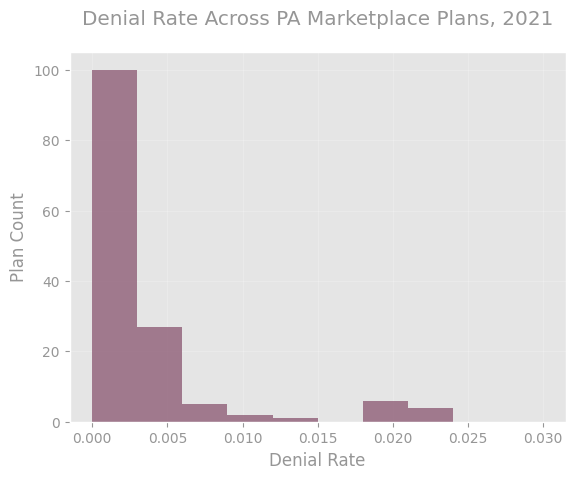

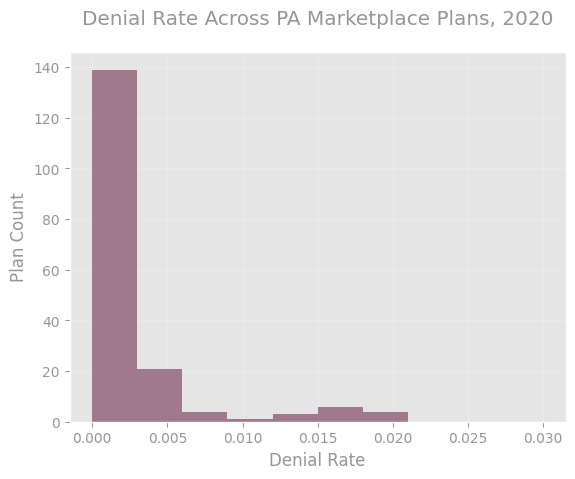

In [85]:
# NMN Denial Rate Distributions Across Plans
for year_df in year_dfs:
    year = year_df["data_plan_year"].iloc[0]
    plot_hist(
        year_df["nmn_denial_rate"],
        bins=np.linspace(0, 0.03, 11),
        title=f"Denial Rate Across PA Marketplace Plans, {year}",
        y_label="Plan Count",
        x_label="Denial Rate",
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, "nmn_denial_rate_plan_distribution_{year}.png"
        ),
    )

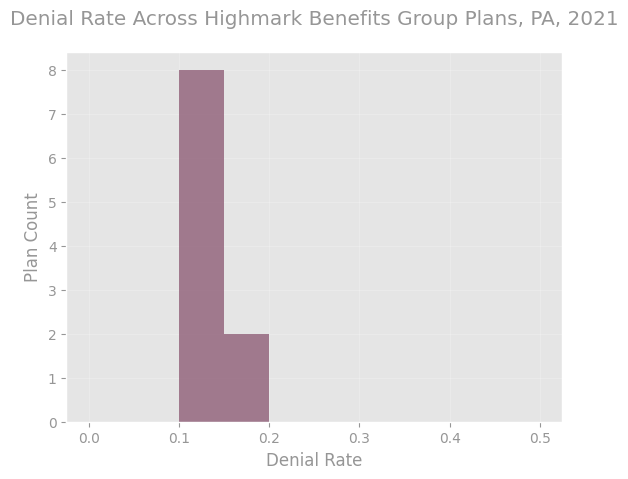

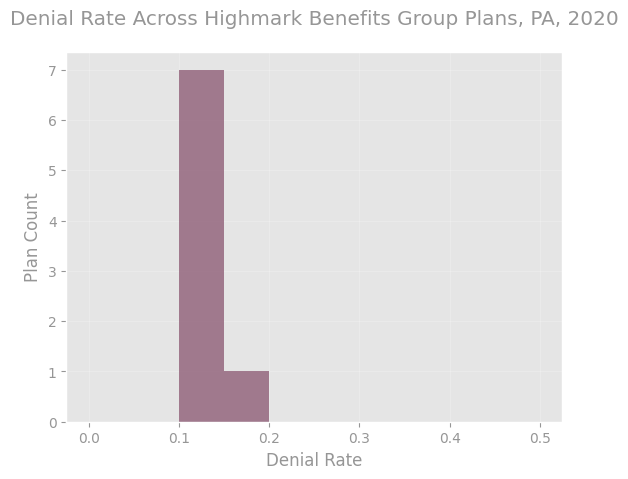

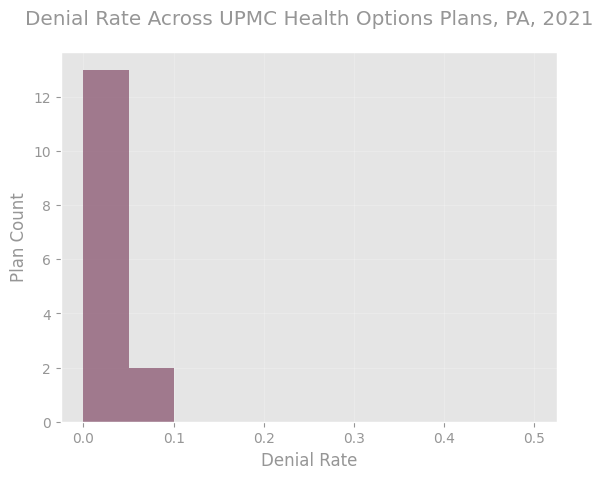

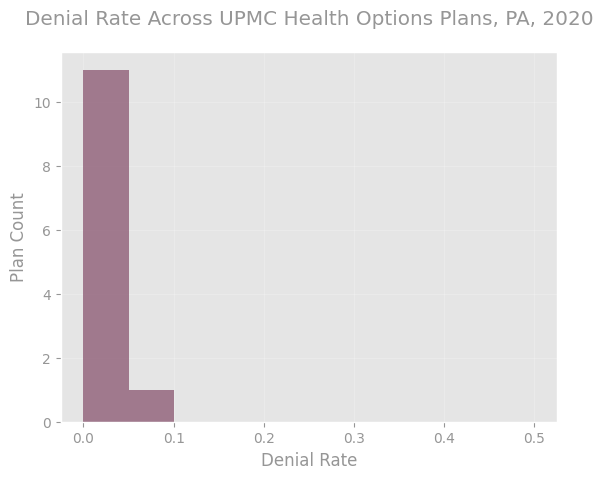

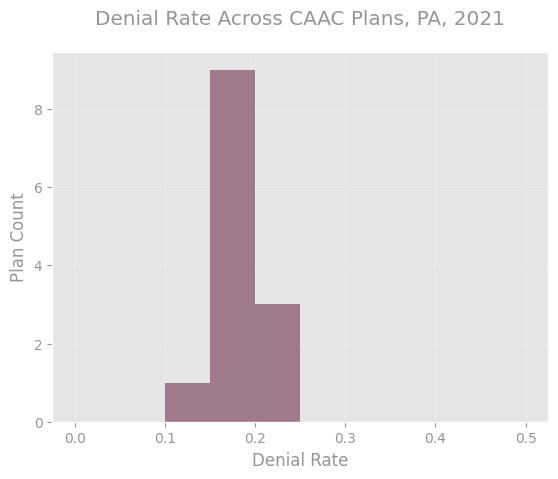

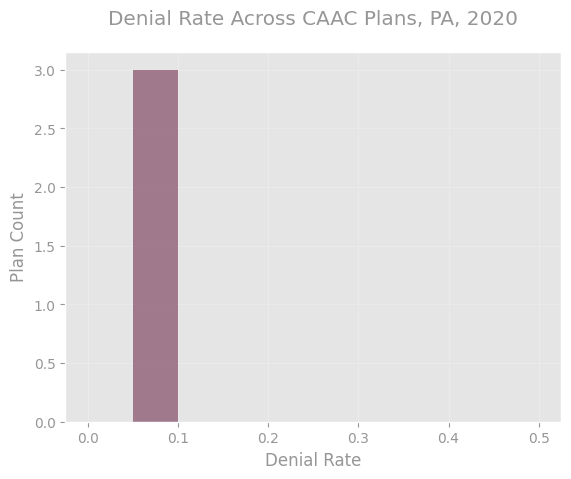

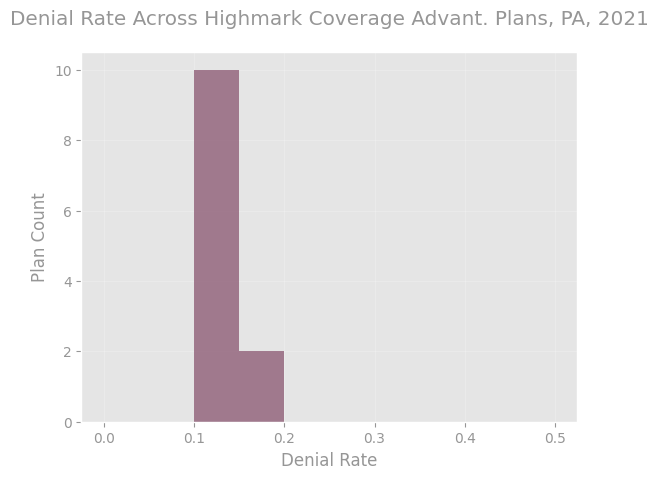

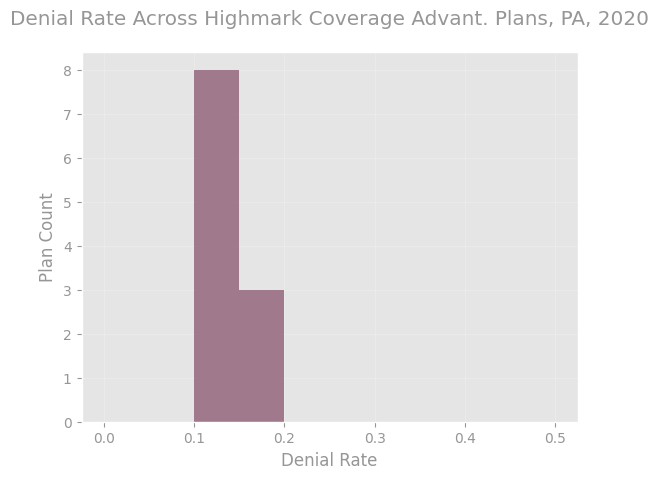

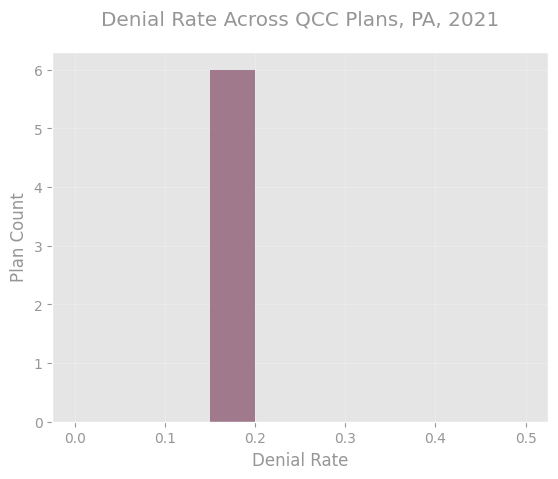

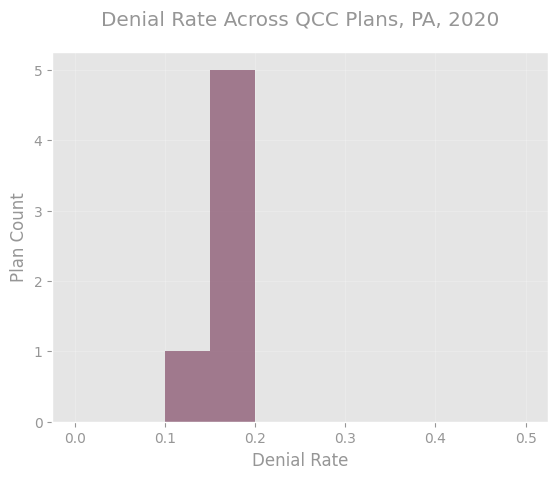

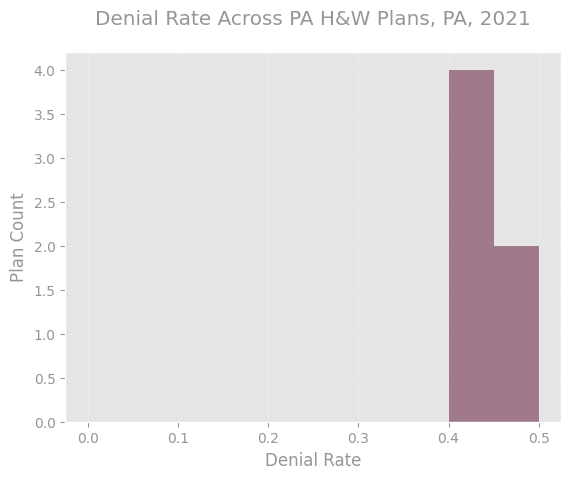

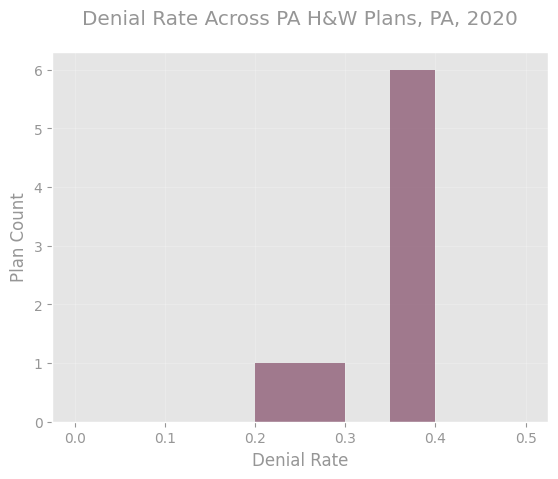

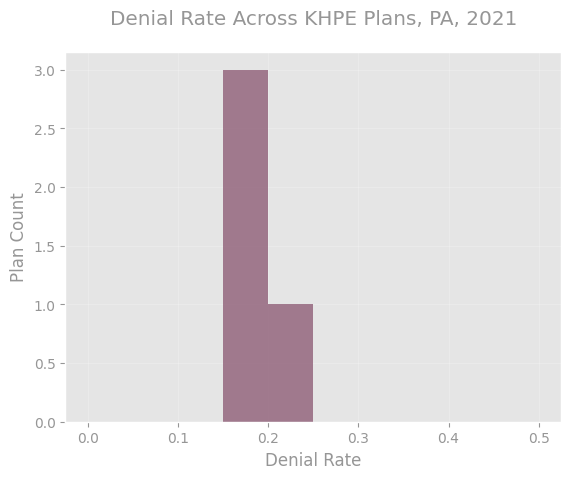

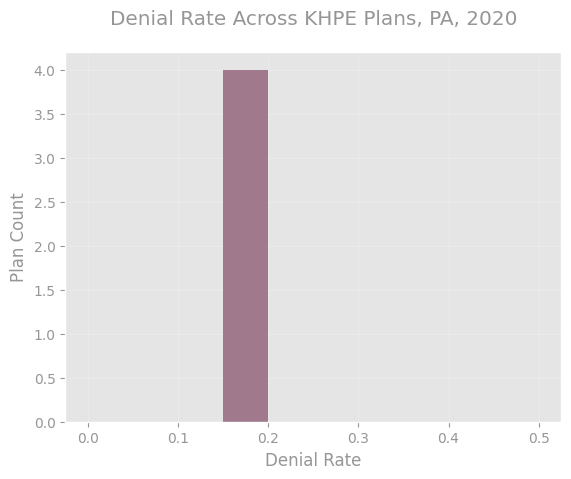

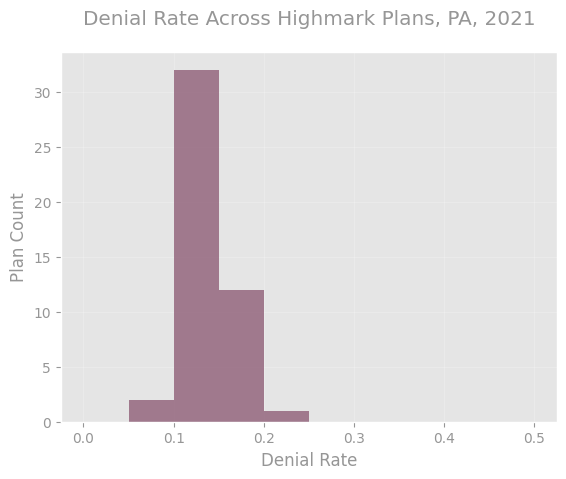

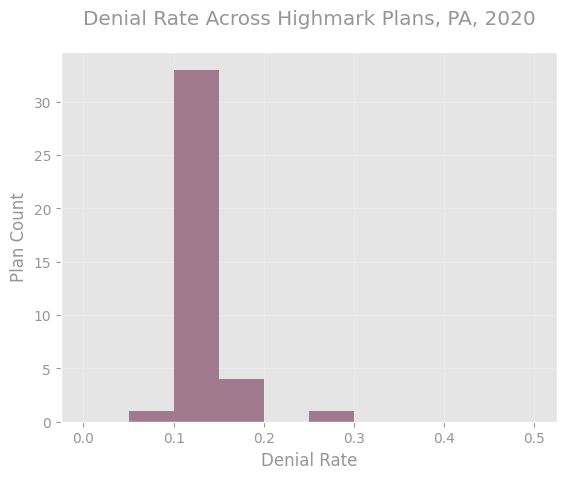

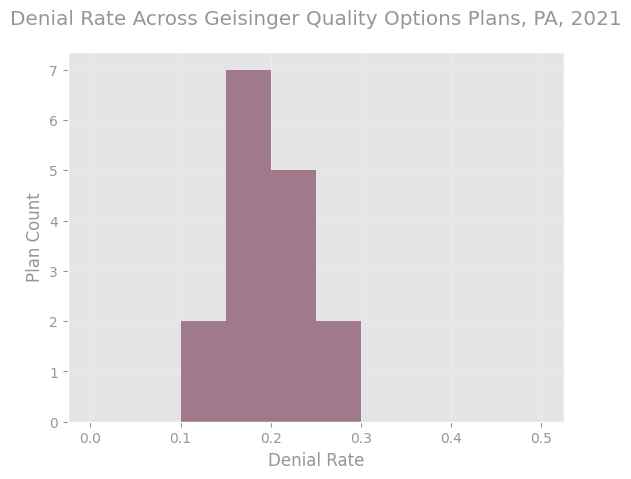

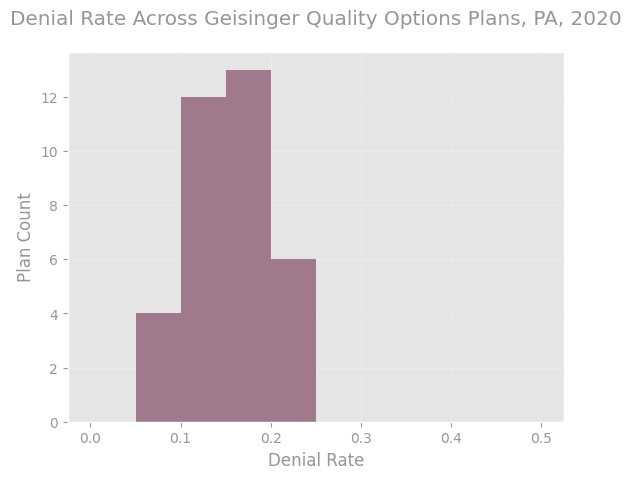

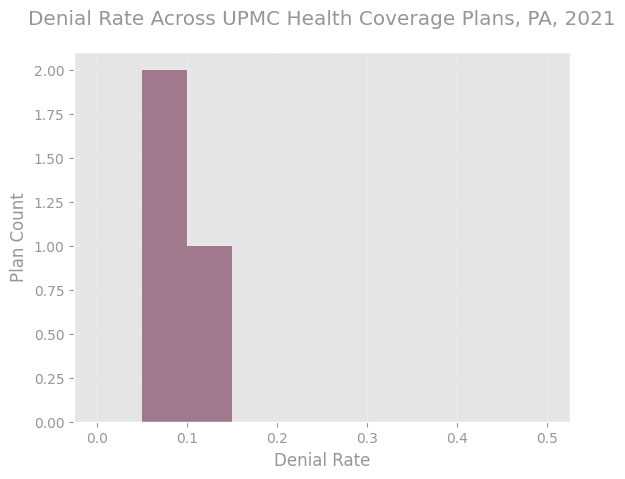

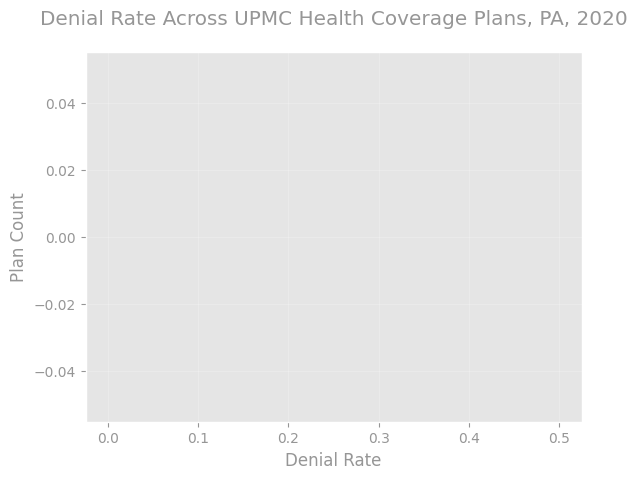

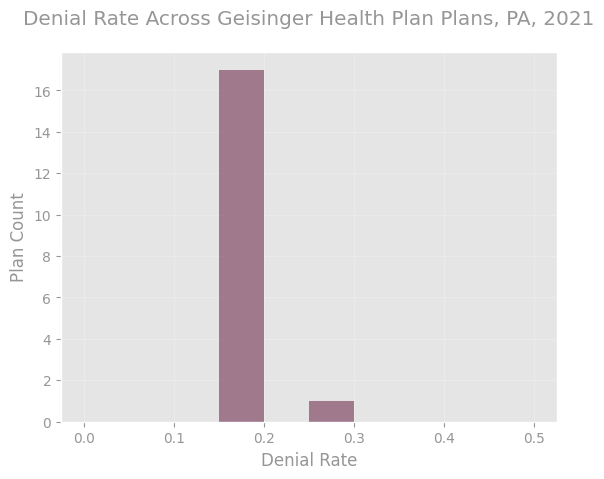

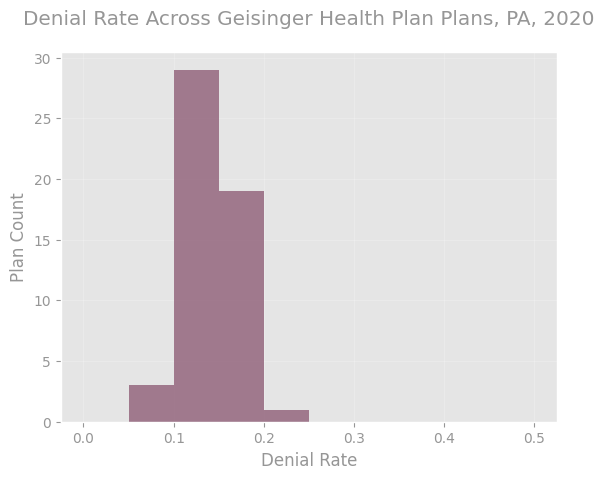

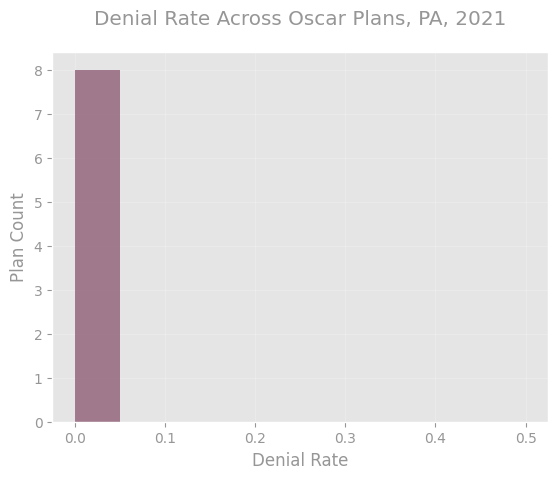

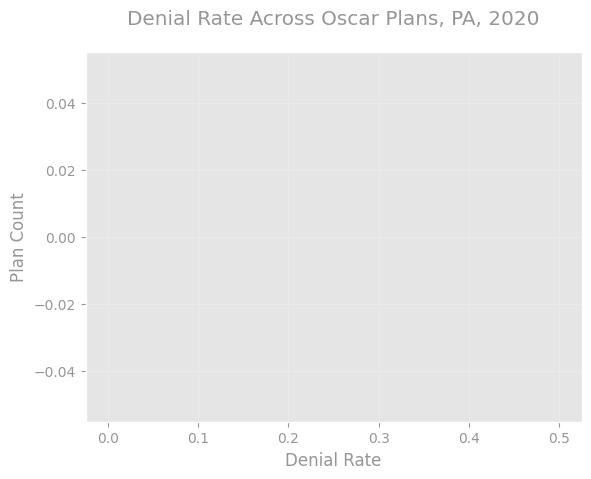

In [87]:
# Plot insurer histograms of plan denial rates, by year, for each insurer
for issuer_id in plan_df["hios_issuer_id"].unique():
    issuer_name = issuer_df[issuer_df["hios_id"] == issuer_id]["insurer_name"].iloc[0]
    for year_df in year_dfs:
        year = year_df["data_plan_year"].iloc[0]
        issuer_plans = year_df[year_df["hios_issuer_id"] == issuer_id]
        denial_rates = issuer_plans["denial_rate"]
        # Hist
        plot_hist(
            denial_rates,
            bins=np.linspace(0, 0.5, 11),
            title=f"Denial Rate Across {issuer_name} Plans, PA, {year}",
            y_label="Plan Count",
            x_label="Denial Rate",
            save_path=os.path.join(
                OUTPUT_IMAGE_DIR,
                f"issuer_{issuer_name}_denial_rate_distribution_{year}.png",
            ),
        )